<a href="https://colab.research.google.com/github/n1la9jan/AnimalPrediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [5]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

# Setting to Cuda

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cuda


# Loading image to Dataframe

In [7]:
image_path = []
labels = []
for i in os.listdir("./dataset"):
  for label in os.listdir(f"./dataset/{i}"):
    for img in os.listdir(f"./dataset/{i}/{label}"):
      image_path.append(f"./dataset/{i}/{label}/{img}")
      labels.append(label)

df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
df.head()

,image_path,labels
0,./dataset/train/cat/flickr_cat_000002.jpg,cat
1,./dataset/train/cat/flickr_cat_000003.jpg,cat
2,./dataset/train/cat/flickr_cat_000004.jpg,cat
3,./dataset/train/cat/flickr_cat_000005.jpg,cat
4,./dataset/train/cat/flickr_cat_000006.jpg,cat


# Data Split

In [8]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)
val = test.sample(frac = 0.5)
test = test.drop(val.index)

#show shapes
print(f"Train data {train.shape}\nVal Data = {val.shape}\nTest Data = {test.shape}")


Train data (11291, 2)
Val Data = (2420, 2)
Test Data = (2419, 2)


# Preprocessing

In [9]:
#convert the label in integer
label_encoder = LabelEncoder()
label_encoder.fit(df['labels'])

#transform all the images in an universal size
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

# Custom Dataset Class & Object

In [10]:
class CustomImageDataset(Dataset):
  def __init__(self, df, transform = None):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(df['labels'])).to(device)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    image_path = self.df.iloc[index, 0]
    #assigned labels column as label
    label = self.labels[index]
    image = Image.open(image_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

      return image, label

In [11]:
train_dataset = CustomImageDataset(df=train, transform=transform)
val_dataset = CustomImageDataset(df=val, transform=transform)
test_dataset = CustomImageDataset(df=test, transform=transform)

In [12]:
#visualisation of the output
train_dataset.__getitem__(2)
label_encoder.inverse_transform([2])

array(['wild'], dtype=object)

# Visualise the images

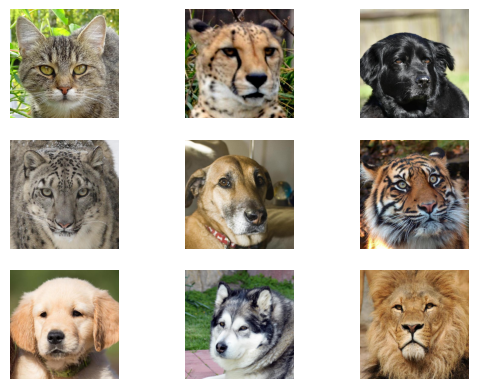

In [13]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

# HyperParameters

In [14]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True)

# Model Building

In [15]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding = 1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)

    self.pooling = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)
    self.output = nn.Linear(128, len(df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x

In [16]:
model = Net().to(device)

In [19]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

# Model Training

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [21]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()

    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc


  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))

  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100, 4))
  total_acc_val_plot.append(round(round(total_acc_val/val_dataset.__len__()) * 100, 4))


  print(f'''
  Epoch = {epoch + 1}/{EPOCHS}, Train Loss = {round(total_loss_train/1000, 4)}, Train Accuracy = {round((total_acc_train/train_dataset.__len__()) * 100, 4)},
  Validation Loss = {round(total_loss_val/1000, 4)}, Validation Accuracy = {round(round(total_acc_val/val_dataset.__len__()) * 100, 4)}
  ''')



  Epoch = 1/10, Train Loss = 0.3483, Train Accuracy = 79.5324,
  Validation Loss = 0.0357, Validation Accuracy = 100
  

  Epoch = 2/10, Train Loss = 0.1516, Train Accuracy = 92.1708,
  Validation Loss = 0.0261, Validation Accuracy = 100
  

  Epoch = 3/10, Train Loss = 0.1001, Train Accuracy = 94.872,
  Validation Loss = 0.0248, Validation Accuracy = 100
  

  Epoch = 4/10, Train Loss = 0.0714, Train Accuracy = 96.4574,
  Validation Loss = 0.0172, Validation Accuracy = 100
  

  Epoch = 5/10, Train Loss = 0.052, Train Accuracy = 97.4404,
  Validation Loss = 0.0188, Validation Accuracy = 100
  

  Epoch = 6/10, Train Loss = 0.0383, Train Accuracy = 98.0073,
  Validation Loss = 0.0201, Validation Accuracy = 100
  

  Epoch = 7/10, Train Loss = 0.0258, Train Accuracy = 98.7158,
  Validation Loss = 0.0194, Validation Accuracy = 100
  

  Epoch = 8/10, Train Loss = 0.0189, Train Accuracy = 99.0346,
  Validation Loss = 0.0214, Validation Accuracy = 100
  

  Epoch = 9/10, Train Loss = 0.01

In [22]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        prediction = model(inputs)
        acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(prediction, labels)
        total_loss_test += test_loss.item()
print(f"Test Loss = {round(total_loss_test/1000, 4)}, Test Accuracy = {round((total_acc_test/test_dataset.__len__()) * 100, 4)}")


Test Loss = 0.0197, Test Accuracy = 96.3621


# Loss and Accurace over Epochs

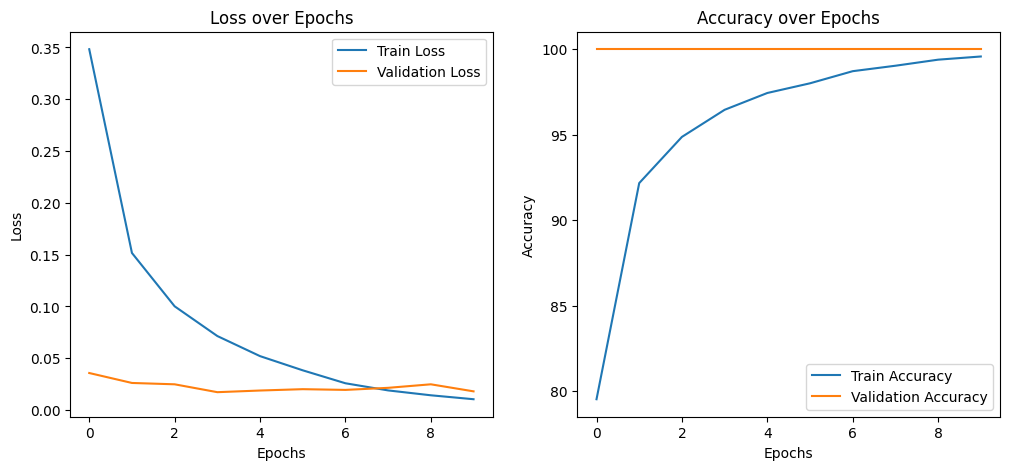

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(total_loss_train_plot, label='Train Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(total_acc_train_plot, label='Train Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

# Testing

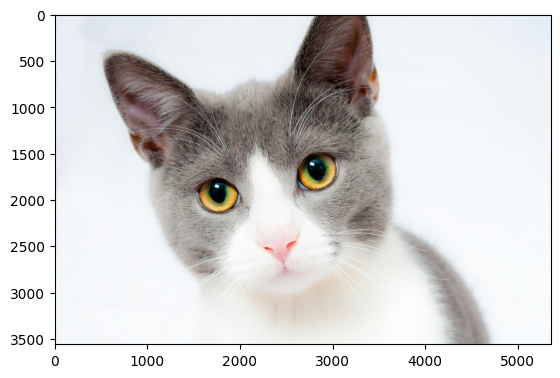


Prediction: 



array(['cat'], dtype=object)

In [34]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

## Visualize the image
image = Image.open("./test_image/cat.jpg")
plt.imshow(image)
plt.show()


## Predict
print()
print("Prediction: \n")
predict_image("./test_image/cat.jpg")

# Exporting the Model

In [31]:
torch.save(model.state_dict(), "animal_model.pth")
print("Model state dictionary saved to model.pth")

Model state dictionary saved to model.pth


In [32]:
import pickle

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Label encoder saved to label_encoder.pkl")

Label encoder saved to label_encoder.pkl
